In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.3.0'

### 1)Linear Classifier for CIFAR10

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape)
print('y_test: ',y_test.shape)
print('y_test[0]',y_test[0])

K = len(np.unique(y_train)) # Number of Classes
print('Number of classes: ',K)

x_train:  (50000, 32, 32, 3)
y_test:  (10000, 1)
y_test[0] [3]
Number of classes:  10


In [4]:
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10, 32x32x3=3072
# Din = 784 # MINIST

# Normalize pixel values: numpy works in one datatype(weights,features):float, faster training,
x_train, x_test = x_train / 255.0, x_test / 255.0


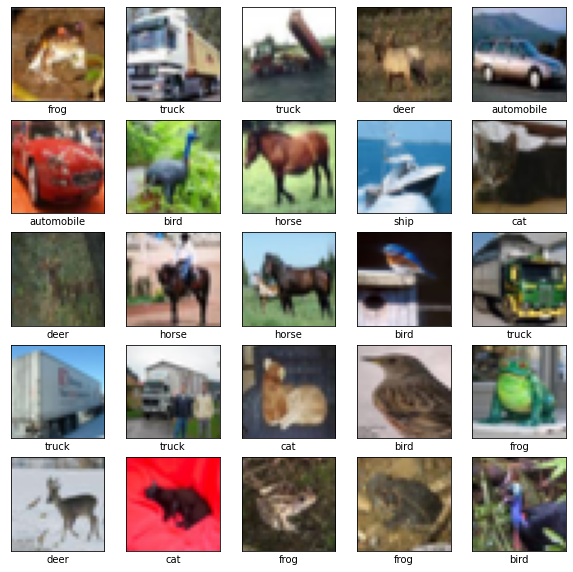

In [5]:
#verify data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [6]:
#centering the data and making range similar in order to get stable gradients
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

#re-classify the y(label) sets as categorical: onehot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

#resize x set into a collection of rows, each row is an image
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

y_train: (50000, 10)
y_test: (10000, 10)
x_train: (50000, 3072)
x_test: (10000, 3072)


In [7]:
#initialize the Weight matrix and bias 
std=1e-5
w1 = std*np.random.randn(Din, K)
b1 = np.zeros(K)
print("w1:", w1.shape)
print("b1:", b1.shape)

w1: (3072, 10)
b1: (10,)


In [8]:
#parameters
batch_size = Ntr    #set batchsize to entire trainingset size
iterations = 300
lr = 0.015         #learning rate
lr_decay= 1     #learning rate decay
reg = 0          #regularization parameter
loss_history = []
train_acc_history = []
val_acc_history = []

#fix seed for random number generator
seed = 0
rng = np.random.default_rng(seed=seed)

In [9]:
for t in range(iterations+1):
    batch_indices = np.random.choice(Ntr,batch_size)
    rng.shuffle(batch_indices)
    x = x_train[batch_indices]
    y = y_train[batch_indices]

    # Forward pass
    y_pred = x.dot(w1) + b1
    loss = (1./batch_size)* np.square(y_pred-y).sum()  + reg*(np.sum(w1*w1))
    loss_history.append(loss)
    
    if t%10 == 0:
        print('iteration %d/%d: loss= %f' % (t,iterations,loss))
    
    dy_pred = (1./batch_size)*2.0*(y_pred-y)
    dw1 = x.T.dot(dy_pred) + reg*w1
    db1 = dy_pred.sum(axis=0)

    # Backward pass
    w1 -= lr*dw1
    b1 -= lr*db1
    lr *= lr_decay


iteration 0/300: loss= 1.000013
iteration 10/300: loss= 0.872152
iteration 20/300: loss= 0.837685
iteration 30/300: loss= 0.820973
iteration 40/300: loss= 0.810494
iteration 50/300: loss= 0.803375
iteration 60/300: loss= 0.797850
iteration 70/300: loss= 0.796470
iteration 80/300: loss= 0.795326
iteration 90/300: loss= 0.792037
iteration 100/300: loss= 0.791346
iteration 110/300: loss= 0.788895
iteration 120/300: loss= 0.788172
iteration 130/300: loss= 0.787548
iteration 140/300: loss= 0.787250
iteration 150/300: loss= 0.786401
iteration 160/300: loss= 0.786910
iteration 170/300: loss= 0.786174
iteration 180/300: loss= 0.786005
iteration 190/300: loss= 0.786820
iteration 200/300: loss= 0.784971
iteration 210/300: loss= 0.785914
iteration 220/300: loss= 0.785138
iteration 230/300: loss= 0.783061
iteration 240/300: loss= 0.782529
iteration 250/300: loss= 0.783442
iteration 260/300: loss= 0.782654
iteration 270/300: loss= 0.781323
iteration 280/300: loss= 0.781947
iteration 290/300: loss= 

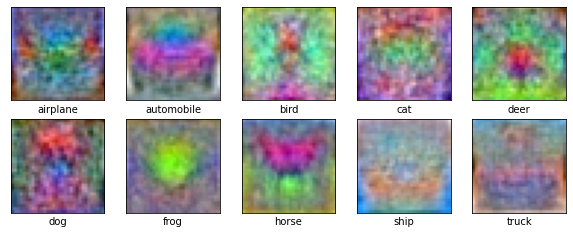

In [10]:
 # W is effectively 10 separate linear classifiers: one classifier per column of W 
 # Displaying w as images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    w = w1[:,i]
    wnorm = (w-min(w))/max(w) #+ mean_image.reshape(3072)
    wnorm = wnorm/max(wnorm)
    plt.imshow(wnorm.reshape((32,32,3)), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays need the extra index
    plt.xlabel(class_names[i])
plt.show()


In [11]:
print(w1.shape)
w1_test = w1[:,1]
print(w1_test.shape)
print(w1_test[:100])

(3072, 10)
(3072,)
[-1.12187335e-03 -2.07903412e-03 -1.98818147e-03  1.29495071e-05
 -9.95779217e-04 -1.06720960e-03  6.70182933e-04 -3.34159058e-04
 -3.97599783e-04 -1.70152212e-05 -1.29052891e-03 -1.21732658e-03
  6.09739487e-04 -5.32424827e-04 -8.59276252e-04 -3.18290874e-04
 -1.05504300e-03 -1.70449380e-03  2.32966877e-04 -9.61653910e-04
 -2.10980321e-03  1.52849678e-04 -1.41547403e-03 -2.74406019e-03
 -6.06701369e-05 -1.60210689e-03 -2.87913624e-03  5.45631846e-04
 -1.20396751e-03 -2.97260977e-03  5.79708918e-04 -8.52346062e-04
 -2.61921693e-03  1.19965626e-03 -7.26057866e-05 -1.68291980e-03
  2.83350572e-03  1.70162041e-03  1.99775628e-04  1.76713098e-03
  6.59527549e-04 -2.79847297e-04  1.15800207e-03  1.68299093e-04
 -2.43279545e-04  1.39302008e-03  4.30753057e-04 -2.07852939e-04
  4.83342019e-04 -4.60576659e-04 -1.89605118e-03  4.28209563e-05
 -1.00233148e-03 -2.32548709e-03  4.07283459e-04 -6.81745634e-04
 -1.36265204e-03  8.05532172e-04 -3.83758031e-04 -7.72692910e-04
  1.47

[0.46143057 0.41357199 0.41811467 0.51817235 0.46773534 0.46416379
 0.55103439 0.50081673 0.49764465 0.5166741  0.45299769 0.45665785
 0.54801219 0.49090333 0.47456057 0.50161014 0.46477212 0.43229922
 0.52917334 0.46944163 0.41203352 0.52516744 0.44675037 0.38032031
 0.51449133 0.43741862 0.37356643 0.54480677 0.45732581 0.3688927
 0.54651064 0.47490708 0.38656254 0.57750836 0.51389454 0.43337793
 0.65920175 0.60260685 0.52751376 0.60588241 0.55050162 0.50353235
 0.57542562 0.52593992 0.50536075 0.58717666 0.53906276 0.5071321
 0.54169224 0.49449577 0.42272124 0.51966594 0.46740773 0.4012492
 0.53788927 0.4834372  0.4493915  0.55780193 0.49833675 0.47888979
 0.59117627 0.5208837  0.48079503 0.58903493 0.51031165 0.47300045
 0.55990528 0.50109329 0.47750256 0.58843971 0.54005871 0.52221372
 0.58907697 0.54253448 0.54642983 0.55856156 0.54770024 0.5689806
 0.54139109 0.54285251 0.54859813 0.53874028 0.51971526 0.53276241
 0.51085967 0.47388164 0.51721814 0.50030281 0.4585486  0.50953341

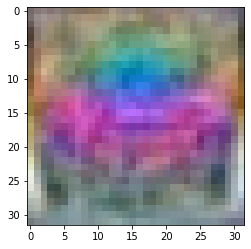

In [12]:
w1norm = (w1_test-min(w1_test))/max(w1_test)
w1norm = w1norm/max(w1norm)
print(w1norm[:100])
plt.figure(figsize=(4,4))
plt.imshow(w1norm.reshape((32,32,3)) )
plt.show()

In [13]:
#Displaying Accuracies